<a href="https://colab.research.google.com/github/prithvijaunjale/Machine-Learning/blob/master/multivariate_classification/mvc_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Embedding, Concatenate, LayerNormalization
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold

In [ ]:
def notify():
    import IPython.display as display
    return display.Audio(url='http://dl.dlmusics.ir/Music/2019/Tones%20and%20I/Tones%20and%20I%20-%20Dance%20Monkey.mp3', autoplay=True)

In [ ]:
!unzip doctor_train.csv.zip

Archive:  doctor_train.csv.zip
  inflating: doctor_train.csv        


In [ ]:
all_cat_vars = ['Profession', 'Status', 'edu', 'Irregular', 'residence', 'prev_diagnosed', 'communication', 'Month', 'side_effects']
categorical_vars = ['Profession', 'Status', 'edu', 'communication', 'Month', 'side_effects']
continuous_vars = ['age', 'Money', 'day', 'Time', 'Doctor_visits', 'last_visit', 'cured_in']

def load_data(csv_file, encode_cat='onehot'):
    df = pd.read_csv(csv_file)
    df = df.drop(columns=['ID'])
    df = df.replace({'no':0, 'yes':1})
    
    # impute missing values
    for col in all_cat_vars:
        df[col] = df[col].fillna(df[col].value_counts().index[0])
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    df[continuous_vars] = imputer.fit_transform(df[continuous_vars].values)

    # encode categorical data
    if encode_cat == 'onehot':
        df = pd.get_dummies(df, columns=categorical_vars)
        for cat_var in categorical_vars:
            remove_col = None
            for col in df.columns:
                if cat_var in col:
                    remove_col = col
                    break 
            if remove_col:
                df = df.drop(columns=[remove_col])
                continue
    elif encode_cat == 'integer':
        for cat_var in all_cat_vars:
            df[cat_var] = pd.factorize(df[cat_var])[0]
            
    # scaling
    scaler = StandardScaler()
    df[continuous_vars] = scaler.fit_transform(df[continuous_vars])
    
    return df

train = load_data('doctor_train.csv', encode_cat='integer')

In [ ]:
print(train.shape)
train.head()

(28196, 17)


,age,Profession,Status,edu,Irregular,Money,residence,prev_diagnosed,communication,day,Month,Time,Doctor_visits,last_visit,cured_in,side_effects,Y
0,-1.036003,0,0,0,0,0.036608,0,0,0,-0.453097,0,-0.569809,0.400803,-0.413892,-0.235465,0,0
1,-0.557958,1,0,1,0,-0.356285,0,0,1,0.624805,1,-0.674441,-0.571413,-0.413892,-0.235465,0,0
2,0.015696,0,1,0,0,1.555927,1,0,1,-0.093797,2,-0.724819,-0.247341,-0.413892,-0.235465,0,0
3,-0.844785,2,1,2,0,-0.235904,0,1,0,-0.932165,3,1.030669,-0.571413,-0.413892,-0.235465,0,0
4,-0.175522,3,1,1,0,0.410981,0,0,0,0.145737,4,-0.523306,-0.571413,-0.413892,-0.235465,0,0


In [ ]:
ratio = list(train['Y'].value_counts())
imb_ratio = max(ratio) / min(ratio)
imb_ratio

7.52100332426715

In [ ]:
def split(df):
    y = df['Y']
    X = df[[x for x in df.columns if x != 'Y']]
    return X, y

X, y = split(train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('train:', X_train.shape, y_train.shape)
print('test:', X_test.shape, y_test.shape)

train: (22556, 16) (22556,)
test: (5640, 16) (5640,)


In [ ]:
# oversampling
OVERSAMPLE = False
if OVERSAMPLE:
    from imblearn.over_sampling import RandomOverSampler

    oversample = RandomOverSampler(sampling_strategy=0.5, random_state=0)
    X_over, y_over = oversample.fit_resample(X_train, y_train)

In [ ]:
# prepare data for categorical embeddings
def prepare_cat_inputs(X):
    X_cat = list()
    for cat_var in categorical_vars:
        X_cat.append(X[cat_var])
    return X_cat

def prepare_cont_inputs(X):
    X_cont = X[continuous_vars]
    X_cont = X_cont.values.reshape(X_cont.shape[0], 1, X_cont.shape[1])
    return X_cont

X_train_cat = prepare_cat_inputs(X_train)
X_test_cat = prepare_cat_inputs(X_test)
X_train_cont = prepare_cont_inputs(X_train)
X_test_cont = prepare_cont_inputs(X_test)

print('Categorical inputs:', len(X_train_cat), len(X_test_cat))
print('Continuous dim:', X_train_cont.shape, X_test_cont.shape)

Categorical inputs: 6 6
Continuous dim: (22556, 1, 7) (5640, 1, 7)


In [ ]:
# prepare each input head
in_cat_layers = list()
em_cat_layers = list()
for i in range(len(X_train_cat)):
    n_labels = len(np.unique(X_train_cat[i]))
    in_layer = Input(shape=(1,))
    em_layer = Embedding(n_labels, min((n_labels+1)//2, 50))(in_layer)
    # em_layer = Embedding(n_labels, 50)(in_layer)
    in_cat_layers.append(in_layer)
    em_cat_layers.append(em_layer)

In [ ]:
cont_input = Input(shape=(1, X_train_cont.shape[2]), name='cont_input')
merge1 = Concatenate(name='cat_embed')(em_cat_layers)
merge2 = Concatenate(name='cat_plus_cont')([merge1, cont_input])
normalized = BatchNormalization(name='normalized')(merge2)
dropout1 = Dropout(0.2, name='dropout1')(normalized)
hidden1 = Dense(16, activation='relu', kernel_initializer='he_normal', name='hidden1')(dropout1)
dropout2 = Dropout(0.2, name='dropout2')(hidden1)
hidden2 = Dense(10, activation='relu', name='hidden2')(dropout2)
output = Dense(1, activation='sigmoid', name='output')(hidden2)
model = Model(inputs=[in_cat_layers, cont_input], outputs=[output, normalized])

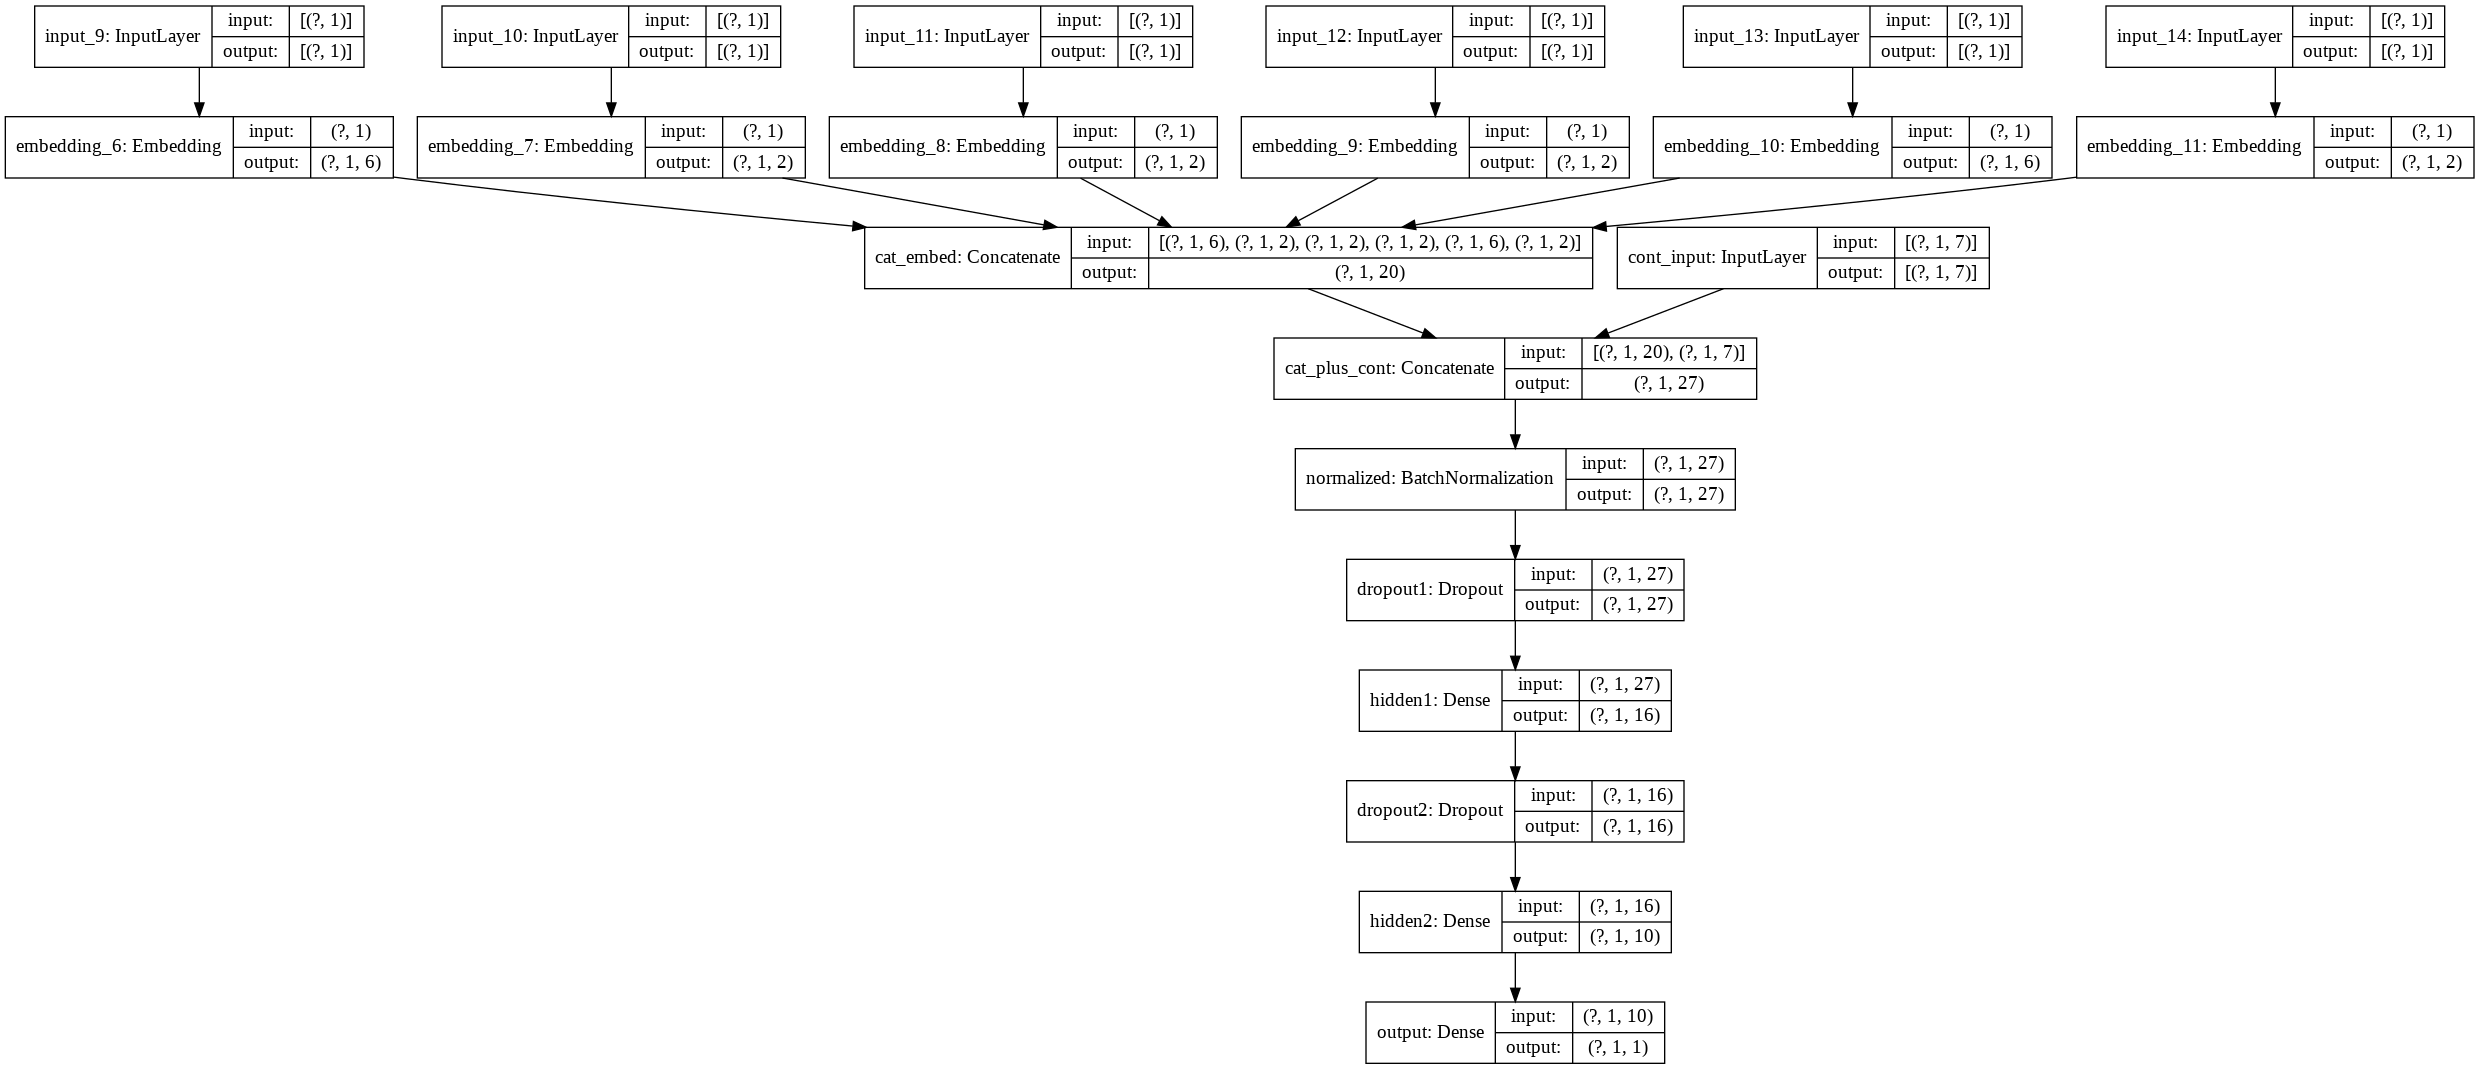

In [ ]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# plot graph
plot_model(model, show_shapes=True, to_file='embeddings.png')

In [ ]:
weights = {0:1, 1:imb_ratio}  
history = model.fit([X_train_cat, X_train_cont], y_train, class_weight=weights, epochs=10, verbose=1, validation_split=0.2, batch_size=32)

Epoch 1/10
564/564 [==============================] - 4s 7ms/step - loss: 4.7441 - output_loss: 1.1061 - normalized_loss: 3.6380 - output_accuracy: 0.5953 - normalized_accuracy: 3.8794e-04 - val_loss: 2.0873 - val_output_loss: 0.4604 - val_normalized_loss: 1.6269 - val_output_accuracy: 0.8229 - val_normalized_accuracy: 0.0000e+00
Epoch 2/10
564/564 [==============================] - 4s 7ms/step - loss: 4.0696 - output_loss: 0.8969 - normalized_loss: 3.1728 - output_accuracy: 0.7564 - normalized_accuracy: 3.8794e-04 - val_loss: 1.9031 - val_output_loss: 0.4552 - val_normalized_loss: 1.4478 - val_output_accuracy: 0.8129 - val_normalized_accuracy: 0.0000e+00
Epoch 3/10
564/564 [==============================] - 4s 7ms/step - loss: 3.8141 - output_loss: 0.8676 - normalized_loss: 2.9465 - output_accuracy: 0.7652 - normalized_accuracy: 7.2046e-04 - val_loss: 1.7811 - val_output_loss: 0.4153 - val_normalized_loss: 1.3658 - val_output_accuracy: 0.8231 - val_normalized_accuracy: 2.2163e-04
Epoc

In [ ]:
y_pred = model.predict([X_test_cat, X_test_cont])
y_pred[1][0]

array([[-0.63915324,  0.16559976, -0.41219005,  0.16456956,  0.13460293,
         0.16217744, -0.8153615 ,  0.14427185,  0.1237216 ,  0.13619328,
        -0.64211   ,  0.21146667,  0.18062413, -0.26148778, -1.0952251 ,
         0.1981933 , -1.0618404 ,  0.14462765, -1.1001886 ,  0.22622323,
        -0.36789793, -0.3047431 , -0.4293409 , -0.75168836, -0.43343002,
         0.78194934,  0.59466684]], dtype=float32)

In [ ]:
y_pred = model.predict([X_test_cat, X_test_cont])[0]

pred = []
for item in y_pred.tolist():
    pred.append(round(item[0][0]))

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
print('Accuracy:', accuracy_score(list(y_test), pred))
print('f1 score:', f1_score(list(y_test), pred))
print('ROC-AUC:', roc_auc_score(list(y_test), pred))
print('\nConfusion matrix:')
confusion_matrix(list(y_test), pred)

Accuracy: 0.826063829787234
f1 score: 0.5464632454923717
ROC-AUC: 0.8333649121276723

Confusion matrix:


array([[4068,  871],
       [ 110,  591]])

In [ ]:
# make submission
test = load_data('doctor_test.csv', encode_cat='integer')
X_eval_cat = prepare_cat_inputs(test)
X_eval_cont = prepare_cont_inputs(test)

y_pred = model.predict([X_eval_cat, X_eval_cont])
pred = []
for item in y_pred.tolist():
    pred.append(round(item[0][0]))

submission = pd.DataFrame()
submission['ID'] = range(0, len(test))

submission['Y'] = pred
submission['Y'] = submission['Y'].replace({0:'no', 1:'yes'})
print(submission.shape)
submission.head()

(3000, 2)


,ID,Y
0,0,no
1,1,yes
2,2,yes
3,3,no
4,4,yes


In [ ]:
submission.to_csv('submission34_nn.csv', index=False)